# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:06:14.060947
Mem. usage decreased to 1559.22 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8471312,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
8471313,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
8471314,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
8471315,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Classify Data

Current Classification (A: Top-Seller, B: Medium-Seller, C: Low-Seller)

A:
At least one in 6 different weeks & mean sales per week greater 0.3

B:
At least one in 6 different weeks & mean sales per week greater 0.1

C:
All the rest


In [6]:
df['Classification'] = 'C'

for i, g in df.groupby(['Site_ID', 'SKU']):
    
    if  (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.4):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'A'
        
    elif (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.1):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'B'

        
# Print summary: number of Time-Series per Classification
df[['Site_ID', 'SKU', 'Classification']].drop_duplicates()[['Classification']].value_counts()

Classification
C                 35871
B                 23052
A                  5859
dtype: int64

In [7]:
df.to_csv('data.csv', index=False)

# Plot Time Series

In [8]:
n_series = 8

In [9]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of lists with Site ID - Article combinations to be vizualized.
            Example: [['g590', 1282277826], ['g115', 1254150002], ['g102', 1264627019]]
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for site, article in samples:
        df_article = sales.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Date').reset_index()

        df_article.plot(x='Date',
                     y='Sales_QTY',
                     title= f'SKU: {article}, Site ID: {site}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

## Class A (Top Seller)

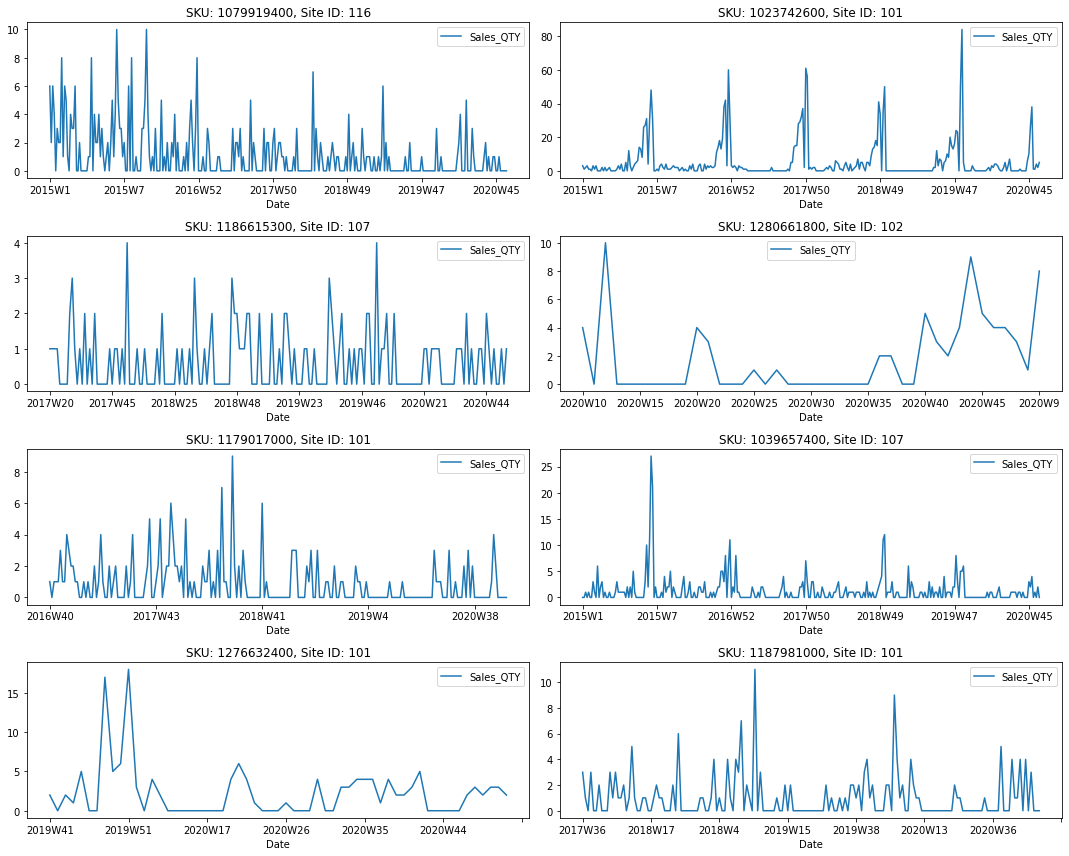

In [10]:
classification = 'A'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class B (Medium Seller)

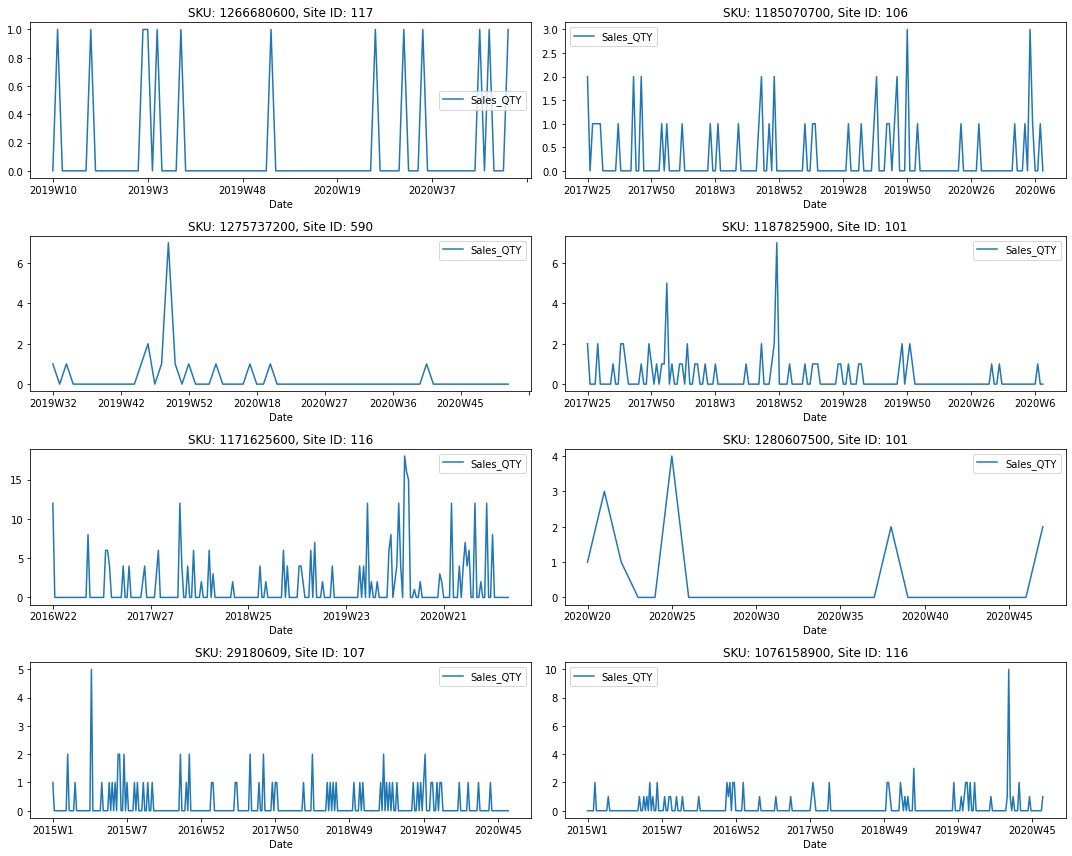

In [11]:
classification = 'B'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class C (Low Seller)

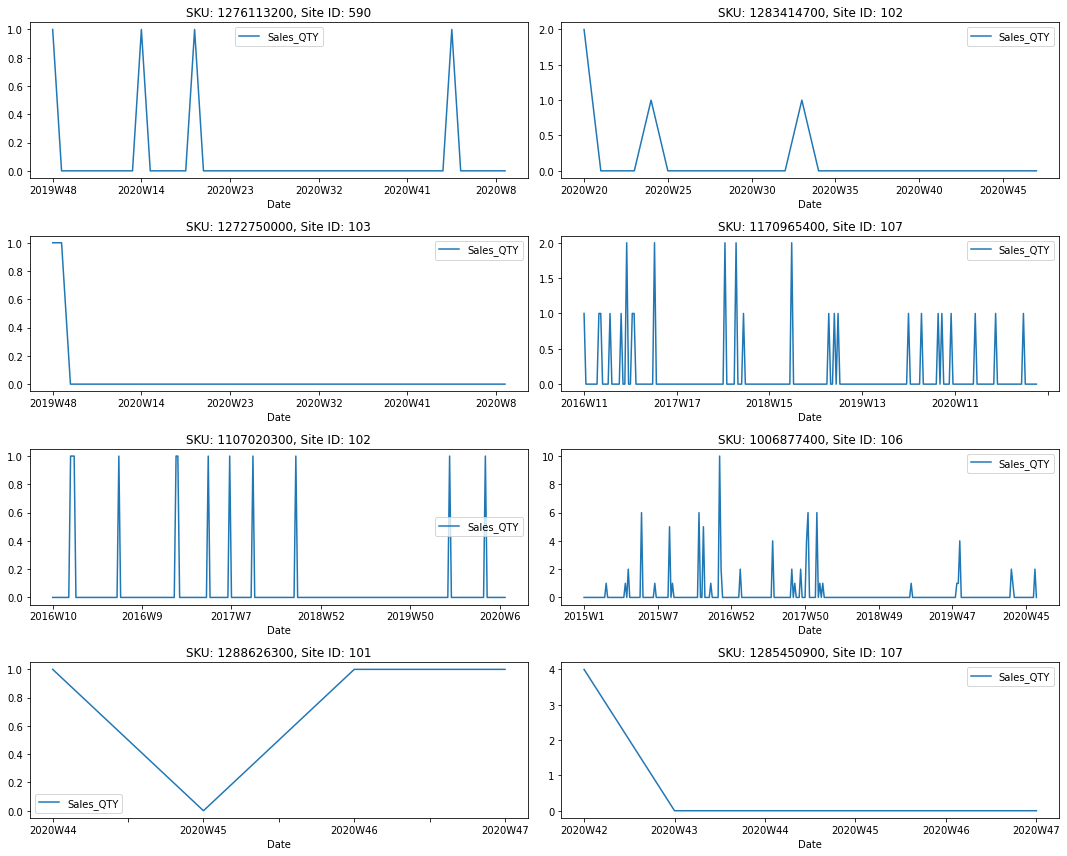

In [12]:
classification = 'C'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

# Feature Engineering

In [115]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [14]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [15]:
# Convert categorical features to integers 
df = utils.encode_categorical(df, cat_features, downcast_cols=False)

# Forecasting

In [323]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=1)

In [324]:
# Store results in dataframe and validate the error at the end.
result_df = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable] )

In [325]:
split_criteria = 'CENSHARE_CAT_1'

df[[split_criteria]].value_counts()

CENSHARE_CAT_1
9                 2204625
16                1875654
14                 989654
0                  829173
2                  776526
18                 749319
6                  313464
12                 250714
15                 212854
4                   86688
11                  64426
13                  46647
3                   31894
10                  22208
8                   13629
1                    2095
7                    1148
5                     409
17                    190
dtype: int64

## Class A (Top Seller)

In [326]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [327]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {i} ******')
        
        df_class = df.loc[df.Classification == 'A'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)



****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7731
[LightGBM] [Info] Number of data points in the train set: 220064, number of used features: 15
[LightGBM] [Info] Start training from score 3.377056
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 57.3185	valid_1's rmse: 52.4286


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	training's rmse: 55.232	valid_1's rmse: 51.7001
Early stopping, best iteration is:
[44]	training's rmse: 55.4364	valid_1's rmse: 51.6229


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7736
[LightGBM] [Info] Number of data points in the train set: 225123, number of used features: 17
[LightGBM] [Info] Start training from score 3.587194
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 93.4778	valid_1's rmse: 73.5301
[50]	training's rmse: 92.0011	valid_1's rmse: 71.2842


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Early stopping, best iteration is:
[51]	training's rmse: 91.8715	valid_1's rmse: 71.2173


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 78542, number of used features: 17
[LightGBM] [Info] Start training from score 4.072498
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 90.3303	valid_1's rmse: 96.6122
[50]	training's rmse: 86.0764	valid_1's rmse: 95.5154
[75]	training's rmse: 84.1492	valid_1's rmse: 95.4549
[100]	training's rmse: 83.0375	valid_1's rmse: 95.3892
Early stopping, best iteration is:
[89]	training's rmse: 83.4609	valid_1's rmse: 95.338


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 196829, number of used features: 17
[LightGBM] [Info] Start training from score 2.403887
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 20.94	valid_1's rmse: 38.2452
Early stopping, best iteration is:
[29]	training's rmse: 20.6286	valid_1's rmse: 38.2183


****** 5W45 ******

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))



****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 1865, number of used features: 11
[LightGBM] [Info] Start training from score 1.842808
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's rmse: 9.9371	valid_1's rmse: 8.03289


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5027
[LightGBM] [Info] Number of data points in the train set: 23095, number of used features: 15
[LightGBM] [Info] Start training from score 4.532224
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 150.357	valid_1's rmse: 108.85
Early stopping, best iteration is:
[24]	training's rmse: 150.587	valid_1's rmse: 108.761


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5949
[LightGBM] [Info] Number of data points in the train set: 40683, number of used features: 16
[LightGBM] [Info] Start training from score 3.730066
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 74.1242	valid_1's rmse: 110.473
[50]	training's rmse: 71.5417	valid_1's rmse: 107.564
[75]	training's rmse: 70.3239	valid_1's rmse: 108.055
Early stopping, best iteration is:
[59]	training's rmse: 70.9834	valid_1's rmse: 107.277


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1429, number of used features: 15
[LightGBM] [Info] Start training from score 4.170160
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 64.8458	valid_1's rmse: 29.7313
[50]	training's rmse: 56.8502	valid_1's rmse: 21.2029
[75]	training's rmse: 50.6263	valid_1's rmse: 17.7044
[100]	training's rmse: 47.0585	valid_1's rmse: 15.6247
[125]	training's rmse: 42.7255	valid_1's rmse: 15.0049
[150]	training's rmse: 39.8141	valid_1's rmse: 14.9762
Early stopping, best iteration is:
[130]	training's rmse: 41.9517	valid_1's rmse: 14.799


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6239
[LightGBM] [Info] Number of data points in the train set: 53020, number of used features: 15
[LightGBM] [Info] Start training from score 3.659596
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 73.9329	valid_1's rmse: 49.6579
[50]	training's rmse: 71.5982	valid_1's rmse: 48.2505
[75]	training's rmse: 70.5094	valid_1's rmse: 48.0335
[100]	training's rmse: 69.6645	valid_1's rmse: 47.98
[125]	training's rmse: 68.857	valid_1's rmse: 47.8447
Early stopping, best iteration is:
[118]	training's rmse: 69.0684	valid_1's rmse: 47.7834


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 304, number of used features: 10
[LightGBM] [Info] Start training from score 4.560103
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's rmse: 127.585	valid_1's rmse: 101.32


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 2140, number of used features: 16
[LightGBM] [Info] Start training from score 3.406370
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 68.415	valid_1's rmse: 25.4916
Early stopping, best iteration is:
[28]	training's rmse: 66.6641	valid_1's rmse: 25.4129


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 8796, number of used features: 14
[LightGBM] [Info] Start training from score 3.396760
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 38.7007	valid_1's rmse: 62.798
[50]	training's rmse: 37.5795	valid_1's rmse: 61.2989
[75]	training's rmse: 36.9677	valid_1's rmse: 60.0694
[100]	training's rmse: 36.5925	valid_1's rmse: 58.8976
[125]	training's rmse: 36.2835	valid_1's rmse: 58.4899
[150]	training's rmse: 35.9751	valid_1's rmse: 58.9152
Early stopping, best iteration is:
[131]	training's rmse: 36.2139	valid_1's rmse: 58.3046


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 6759, number of used features: 14
[LightGBM] [Info] Start training from score 3.834761
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 60.8116	valid_1's rmse: 56.6444
Early stopping, best iteration is:
[13]	training's rmse: 66.1241	valid_1's rmse: 54.7625


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 12500, number of used features: 15
[LightGBM] [Info] Start training from score 4.934230
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 268.212	valid_1's rmse: 226.556
[50]	training's rmse: 254.128	valid_1's rmse: 227.227
Early stopping, best iteration is:
[32]	training's rmse: 262.865	valid_1's rmse: 225.989


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 3028, number of used features: 15
[LightGBM] [Info] Start training from score 4.750480
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 118.72	valid_1's rmse: 56.5618
[50]	training's rmse: 98.3086	valid_1's rmse: 49.3595
[75]	training's rmse: 91.8373	valid_1's rmse: 48.0134
[100]	training's rmse: 87.6103	valid_1's rmse: 47.0415
[125]	training's rmse: 84.9201	valid_1's rmse: 46.8226
[150]	training's rmse: 82.9102	valid_1's rmse: 46.7825
Early stopping, best iteration is:
[134]	training's rmse: 84.0176	valid_1's rmse: 46.7341


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 246, number of used features: 9
[LightGBM] [Info] Start training from score 2.962121
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 22.4737	valid_1's rmse: 14.8159
[50]	training's rmse: 20.5603	valid_1's rmse: 10.4987
Early stopping, best iteration is:
[47]	training's rmse: 20.7913	valid_1's rmse: 9.73789


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [328]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [51.62286323108768, 71.21734392896971, 95.33803393791636, 38.21827582219615, 8.032890389606608, 108.76122481402388, 107.27744356204221, 14.799041898387646, 47.78343480163116, 101.32046941759543, 25.412861103164158, 58.30459721651135, 54.762493708382046, 225.9892021687462, 46.734052063963446, 9.737891209948547, 60.58202951406647]

Crossvalidated RMSE:  66.22906757577877


In [329]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,32.703613,29.900000
3034,46,5,0,1,20.781631,0.000000
5409,46,5,0,2,19.651486,0.000000
8097,46,5,0,3,51.940374,0.000000
9329,46,5,4,3,49.319050,0.000000
...,...,...,...,...,...,...
8414937,46,5,0,8971,100.902334,24.900000
8414981,46,5,0,8972,100.902334,105.040001
8415015,46,5,0,8973,100.902334,149.500000
8415050,46,5,0,8974,100.902334,104.699997


## Class B (Medium Seller)

In [330]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [331]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {i} ******')
        
        df_class = df.loc[df.Classification == 'B'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)



****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7709
[LightGBM] [Info] Number of data points in the train set: 1103662, number of used features: 16
[LightGBM] [Info] Start training from score 2.730124
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 96.6038	valid_1's rmse: 77.7573
[50]	training's rmse: 70.8069	valid_1's rmse: 74.9958
[75]	training's rmse: 65.5523	valid_1's rmse: 74.779
[100]	training's rmse: 63.0611	valid_1's rmse: 74.8626
Early stopping, best iteration is:
[84]	training's rmse: 64.4467	valid_1's rmse: 74.7503


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8165
[LightGBM] [Info] Number of data points in the train set: 806079, number of used features: 17
[LightGBM] [Info] Start training from score 2.751438
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 619.953	valid_1's rmse: 57.8717
[50]	training's rmse: 233.039	valid_1's rmse: 57.2782
[75]	training's rmse: 142.845	valid_1's rmse: 56.9929
[100]	training's rmse: 119.597	valid_1's rmse: 56.709
[125]	training's rmse: 111.181	valid_1's rmse: 56.5891
[150]	training's rmse: 106.627	valid_1's rmse: 56.4987
[175]	training's rmse: 102.366	valid_1's rmse: 56.43
[200]	training's rmse: 99.9546	valid_1's rmse: 56.3574
Early stopping, best iteration is:
[201]	training's rmse: 99.7972	valid_1's rmse: 56.3573


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7145
[LightGBM] [Info] Number of data points in the train set: 335587, number of used features: 17
[LightGBM] [Info] Start training from score 3.162017
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 192.243	valid_1's rmse: 78.2879


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Early stopping, best iteration is:
[23]	training's rmse: 205.143	valid_1's rmse: 78.283


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5371
[LightGBM] [Info] Number of data points in the train set: 530100, number of used features: 17
[LightGBM] [Info] Start training from score 1.568485
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 15.8048	valid_1's rmse: 27.1058
[50]	training's rmse: 15.4347	valid_1's rmse: 26.6505
[75]	training's rmse: 15.2713	valid_1's rmse: 26.6287
[100]	training's rmse: 15.1817	valid_1's rmse: 26.6133
Early stopping, best iteration is:
[97]	training's rmse: 15.1887	valid_1's rmse: 26.6102


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 7979, number of used features: 14
[LightGBM] [Info] Start training from score 2.008689
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 18.0254	valid_1's rmse: 27.8174
[50]	training's rmse: 17.4636	valid_1's rmse: 28.0553
Early stopping, best iteration is:
[30]	training's rmse: 17.8742	valid_1's rmse: 27.736


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7108
[LightGBM] [Info] Number of data points in the train set: 182930, number of used features: 16
[LightGBM] [Info] Start training from score 3.755011
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 180.67	valid_1's rmse: 100.533
Early stopping, best iteration is:
[10]	training's rmse: 184.262	valid_1's rmse: 99.0212


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6858
[LightGBM] [Info] Number of data points in the train set: 339093, number of used features: 16
[LightGBM] [Info] Start training from score 2.772080
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 55.27	valid_1's rmse: 44.6985


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Early stopping, best iteration is:
[29]	training's rmse: 55.1513	valid_1's rmse: 44.6817


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 15493, number of used features: 15
[LightGBM] [Info] Start training from score 2.762273
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's rmse: 58.3747	valid_1's rmse: 18.4365


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5597
[LightGBM] [Info] Number of data points in the train set: 139588, number of used features: 15
[LightGBM] [Info] Start training from score 2.657775
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 51.3226	valid_1's rmse: 68.9511
[50]	training's rmse: 50.7384	valid_1's rmse: 67.7804
[75]	training's rmse: 50.2883	valid_1's rmse: 67.1849
[100]	training's rmse: 49.9807	valid_1's rmse: 66.9637
Early stopping, best iteration is:
[101]	training's rmse: 49.977	valid_1's rmse: 66.9574


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 4198, number of used features: 14
[LightGBM] [Info] Start training from score 3.468169
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 86.1886	valid_1's rmse: 72.8195
Early stopping, best iteration is:
[6]	training's rmse: 90.961	valid_1's rmse: 71.2156


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1355
[LightGBM] [Info] Number of data points in the train set: 24741, number of used features: 16
[LightGBM] [Info] Start training from score 2.515129
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 44.2495	valid_1's rmse: 108.213
[50]	training's rmse: 41.9786	valid_1's rmse: 107.869
[75]	training's rmse: 40.4402	valid_1's rmse: 107.903
Early stopping, best iteration is:
[55]	training's rmse: 41.6214	valid_1's rmse: 107.814


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 157551, number of used features: 14
[LightGBM] [Info] Start training from score 2.299678
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 25.6093	valid_1's rmse: 27.2915
[50]	training's rmse: 25.3225	valid_1's rmse: 27.0001
[75]	training's rmse: 25.1967	valid_1's rmse: 26.8577


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 24.9633	valid_1's rmse: 26.7698
[125]	training's rmse: 24.7605	valid_1's rmse: 26.6946
[150]	training's rmse: 24.5801	valid_1's rmse: 26.6657
[175]	training's rmse: 24.4126	valid_1's rmse: 26.638
[200]	training's rmse: 24.2272	valid_1's rmse: 26.6386
Early stopping, best iteration is:
[183]	training's rmse: 24.3512	valid_1's rmse: 26.6279


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 37536, number of used features: 15
[LightGBM] [Info] Start training from score 2.971364
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 82.883	valid_1's rmse: 139.676
[50]	training's rmse: 79.2945	valid_1's rmse: 137.564
[75]	training's rmse: 77.1883	valid_1's rmse: 137.516
Early stopping, best iteration is:
[62]	training's rmse: 78.2009	valid_1's rmse: 137.105


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3403
[LightGBM] [Info] Number of data points in the train set: 79749, number of used features: 15
[LightGBM] [Info] Start training from score 4.127625
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 213.506	valid_1's rmse: 81.5638
Early stopping, best iteration is:
[18]	training's rmse: 215.742	valid_1's rmse: 81.1713


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 15267, number of used features: 11
[LightGBM] [Info] Start training from score 2.337994
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 23.6845	valid_1's rmse: 11.3964
[50]	training's rmse: 23.2641	valid_1's rmse: 10.753
[75]	training's rmse: 23.0282	valid_1's rmse: 10.3935
[100]	training's rmse: 22.8706	valid_1's rmse: 10.2475
[125]	training's rmse: 22.7145	valid_1's rmse: 10.1958
[150]	training's rmse: 22.5994	valid_1's rmse: 10.1469
[175]	training's rmse: 22.4794	valid_1's rmse: 10.1419
Early stopping, best iteration is:
[167]	training's rmse: 22.522	valid_1's rmse: 10.1115


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1840, number of used features: 10
[LightGBM] [Info] Start training from score 1.587117
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 11.1139	valid_1's rmse: 8.9531
Early stopping, best iteration is:
[6]	training's rmse: 11.8249	valid_1's rmse: 8.55374


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 10
[LightGBM] [Info] Start training from score 3.800670
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 126.84	valid_1's rmse: 189.828
[50]	training's rmse: 123.319	valid_1's rmse: 170.793
[75]	training's rmse: 121.644	valid_1's rmse: 146.562
[100]	training's rmse: 120.556	valid_1's rmse: 139.988
[125]	training's rmse: 119.218	valid_1's rmse: 133.266
[150]	training's rmse: 117.87	valid_1's rmse: 121.707
[175]	training's rmse: 116.936	valid_1's rmse: 118.411
[200]	training's rmse: 116.058	valid_1's rmse: 113.968
[225]	training's rmse: 115.39	valid_1's rmse: 113.153
[250]	training's rmse: 114.711	valid_1's rms

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 8
[LightGBM] [Info] Start training from score 1.807954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [332]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [74.75026918780104, 56.35733307266125, 78.28296674620732, 26.610183699363986, 27.73596691864162, 99.02124361675186, 44.68166816775861, 18.436501883107216, 66.95742136216359, 71.21558647327535, 107.8139886171353, 26.62794101908916, 137.1049259415494, 81.17128065292346, 10.111456099854431, 8.55374358654319, 111.94088355268073, 10.784700772270257]

Crossvalidated RMSE:  58.78655896498766


In [333]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,32.703613,29.9
3034,46,5,0,1,20.781631,0.0
5409,46,5,0,2,19.651486,0.0
8097,46,5,0,3,51.940374,0.0
9329,46,5,4,3,49.319050,0.0
...,...,...,...,...,...,...
7234118,46,5,8,4331,9.594087,0.0
8289075,46,5,0,7996,5.984377,0.0
8289175,46,5,2,7996,5.984377,24.9
8289243,46,5,4,7996,5.984377,0.0


## Class C (Low Seller)

In [334]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {i} ******')
        
        df_class = df.loc[df.Classification == 'C'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)



****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5189
[LightGBM] [Info] Number of data points in the train set: 867017, number of used features: 16
[LightGBM] [Info] Start training from score 2.169424
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 257.443	valid_1's rmse: 299.603
[50]	training's rmse: 115.562	valid_1's rmse: 252.033
Early stopping, best iteration is:
[39]	training's rmse: 154.292	valid_1's rmse: 239.847


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7072
[LightGBM] [Info] Number of data points in the train set: 830504, number of used features: 17
[LightGBM] [Info] Start training from score 1.635902
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 34.7237	valid_1's rmse: 36.0353
[50]	training's rmse: 34.3423	valid_1's rmse: 35.8383
[75]	training's rmse: 33.9869	valid_1's rmse: 35.7354
[100]	training's rmse: 33.6943	valid_1's rmse: 35.6687
[125]	training's rmse: 33.4391	valid_1's rmse: 35.648
[150]	training's rmse: 33.2546	valid_1's rmse: 35.6619
Early stopping, best iteration is:
[133]	training's rmse: 33.3787	valid_1's rmse: 35.6458


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4525
[LightGBM] [Info] Number of data points in the train set: 327992, number of used features: 17
[LightGBM] [Info] Start training from score 2.307562
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 3298.89	valid_1's rmse: 53.3648


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	training's rmse: 979.076	valid_1's rmse: 52.7183
[75]	training's rmse: 1.05576e+06	valid_1's rmse: 52.6411
[100]	training's rmse: 305161	valid_1's rmse: 52.6241
[125]	training's rmse: 88219.1	valid_1's rmse: 53.2431
Early stopping, best iteration is:
[107]	training's rmse: 215578	valid_1's rmse: 52.5862


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3693
[LightGBM] [Info] Number of data points in the train set: 255351, number of used features: 17
[LightGBM] [Info] Start training from score 1.205973
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 40.8476	valid_1's rmse: 49.5932
[50]	training's rmse: 28.5531	valid_1's rmse: 30.655

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))



[75]	training's rmse: 25.9958	valid_1's rmse: 26.3121
[100]	training's rmse: 24.8591	valid_1's rmse: 23.7515
[125]	training's rmse: 24.1664	valid_1's rmse: 22.6853
[150]	training's rmse: 23.7176	valid_1's rmse: 22.0646
[175]	training's rmse: 23.404	valid_1's rmse: 21.206
[200]	training's rmse: 23.0235	valid_1's rmse: 20.912
[225]	training's rmse: 22.8237	valid_1's rmse: 20.7986
[250]	training's rmse: 22.5829	valid_1's rmse: 20.7178
[275]	training's rmse: 22.4339	valid_1's rmse: 20.6882
Early stopping, best iteration is:
[260]	training's rmse: 22.5128	valid_1's rmse: 20.6419


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 3722, number of used features: 14
[LightGBM] [Info] Start training from score 0.880898
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's rmse: 11.5701	valid_1's rmse: 15.8741


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4582
[LightGBM] [Info] Number of data points in the train set: 563492, number of used features: 16
[LightGBM] [Info] Start training from score 2.587423
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 101.083	valid_1's rmse: 87.5975
[50]	training's rmse: 100.177	valid_1's rmse: 87.3945
Early stopping, best iteration is:
[44]	training's rmse: 100.359	valid_1's rmse: 87.3885


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3556
[LightGBM] [Info] Number of data points in the train set: 443807, number of used features: 16
[LightGBM] [Info] Start training from score 1.822715
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 36.3452	valid_1's rmse: 36.993


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	training's rmse: 35.9638	valid_1's rmse: 36.9131
[75]	training's rmse: 35.7265	valid_1's rmse: 36.8979
[100]	training's rmse: 35.5962	valid_1's rmse: 36.8859
Early stopping, best iteration is:
[86]	training's rmse: 35.6665	valid_1's rmse: 36.8842


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 46976, number of used features: 15
[LightGBM] [Info] Start training from score 1.648058
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's rmse: 36.7652	valid_1's rmse: 13.2678


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1755
[LightGBM] [Info] Number of data points in the train set: 56409, number of used features: 16
[LightGBM] [Info] Start training from score 1.576773
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 31.0886	valid_1's rmse: 39.4654
[50]	training's rmse: 30.5592	valid_1's rmse: 39.1198
[75]	training's rmse: 30.2299	valid_1's rmse: 38.9208
Early stopping, best iteration is:
[76]	training's rmse: 30.2153	valid_1's rmse: 38.9084


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 17618, number of used features: 14
[LightGBM] [Info] Start training from score 2.014255
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's rmse: 51.1398	valid_1's rmse: 64.055


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 780
[LightGBM] [Info] Number of data points in the train set: 19257, number of used features: 16
[LightGBM] [Info] Start training from score 1.776294
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 33.245	valid_1's rmse: 20.5989
[50]	training's rmse: 30.3562	valid_1's rmse: 20.4612
[75]	training's rmse: 28.6465	valid_1's rmse: 20.4643
[100]	training's rmse: 27.6093	valid_1's rmse: 20.1271
Early stopping, best iteration is:
[104]	training's rmse: 27.5529	valid_1's rmse: 20.1063


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 144783, number of used features: 16
[LightGBM] [Info] Start training from score 1.148090
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's rmse: 16.5864	valid_1's rmse: 39.5197


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 40919, number of used features: 16
[LightGBM] [Info] Start training from score 2.499304
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 72.8606	valid_1's rmse: 84.4588
[50]	training's rmse: 68.0474	valid_1's rmse: 82.3541
[75]	training's rmse: 65.2665	valid_1's rmse: 82.1768
Early stopping, best iteration is:
[68]	training's rmse: 66.092	valid_1's rmse: 82.0327


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 117980, number of used features: 16
[LightGBM] [Info] Start training from score 3.098275
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 118.27	valid_1's rmse: 68.731
[50]	training's rmse: 114.851	valid_1's rmse: 68.0743
Early stopping, best iteration is:
[41]	training's rmse: 115.905	valid_1's rmse: 67.9845


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 14
[LightGBM] [Info] Start training from score 1.614276
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 19.3545	valid_1's rmse: 66.9877
[50]	training's rmse: 17.5509	valid_1's rmse: 66.8685
Early stopping, best iteration is:
[35]	training's rmse: 18.4029	valid_1's rmse: 66.1058


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 55 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 11
[LightGBM] [Info] Start training from score 2.464200
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 50.961	valid_1's rmse: 3.54235
[50]	training's rmse: 45.7575	valid_1's rmse: 1.57649
[75]	training's rmse: 40.923	valid_1's rmse: 0.821915
[100]	training's rmse: 36.0232	valid_1's rmse: 0.566209
[125]	training's rmse: 32.2397	valid_1's rmse: 0.438605
[150]	training's rmse: 29.4141	valid_1's rmse: 0.35813
[175]	training's rmse: 27.2384	valid_1's rmse: 0.290304
[200]	training's rmse: 22.8806	valid_1's rmse: 0.216996
[225]	training's rmse: 20.6391	valid_1's rmse: 0.190299
[250]	training's rmse: 18.9625	valid_

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))



****** Split Criteria: CENSHARE_CAT_1 = 55 ******
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 7
[LightGBM] [Info] Start training from score 0.892480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 118, number of used features: 7
[LightGBM] [Info] Start training from score 4.770291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	training's rmse: 100.357	valid_1's rmse: 115.016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [335]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [239.84708003061846, 35.64577294977227, 52.58615061858261, 20.641890640533063, 15.874123928127021, 87.38846749898752, 36.88421655965037, 13.267811017942359, 38.908352368289485, 64.05496117658376, 20.106337750574653, 39.51968948805011, 82.03269512636047, 67.98445282741287, 66.10581423575681, 0.009697341821831079, 0.7679116741460678, 114.78054376821723]

Crossvalidated RMSE:  55.35588716674594


In [336]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,32.703613,29.900000
3034,46,5,0,1,20.781631,0.000000
5409,46,5,0,2,19.651486,0.000000
8097,46,5,0,3,51.940374,0.000000
9329,46,5,4,3,49.319050,0.000000
...,...,...,...,...,...,...
8415100,46,5,4,8975,76.566424,79.199997
8415106,46,5,5,8975,54.327838,0.000000
8415110,46,5,6,8975,38.668586,0.000000
8415115,46,5,7,8975,78.065214,59.400002


## Validate Overall Performance

In [337]:
mean_squared_error(result_df.Prediction, result_df.Turnover, squared=False)

96.1175013451851